**Objective: based on the information available in the dataset, try to predict whether or not an individual would seek treatment for a mental health condition.**

# 1. Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preparation
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#from sklearn.feature_selection import SelectFromModel

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#  2. Data cleaning

In [2]:
# reading the data file and extracting general info from it
survey = pd.read_csv('survey.csv')
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null object
wellness_program             1259 non-null object
seek_help                    1259 non-null object
anonymity                    1259 non-null object
leave                        1259 non-null obj

Only few columns ("state", "work_interfere", "comments") have null values.
<br>
However the "work_interfere" column will be our target column, and unfortunately 20% of its values are missing. We have to manage with these 80% values available.
<br>
Now let's look in detail at the content of all these columns if they need any cleaning.

In [3]:
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
# missing data
missing_values_per_column = survey.isnull().sum().sort_values(ascending=False)
percentage_missing_values = 100*(survey.isnull().sum()/survey.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values_per_column, percentage_missing_values], \
                         axis=1, keys=['Number of missing values', 'Percentage of missing values'])
pmv = 'Percentage of missing values'
missing_data[pmv] = pd.Series(["{0:.2f}%".format(val) for val in missing_data[pmv]],index = missing_data.index)
missing_data

,Number of missing values,Percentage of missing values
comments,1095,86.97%
state,515,40.91%
work_interfere,264,20.97%
self_employed,18,1.43%
benefits,0,0.00%
Age,0,0.00%
Gender,0,0.00%
Country,0,0.00%
family_history,0,0.00%
treatment,0,0.00%


In [5]:
# removing columns not useful for our analysis
survey.drop(['comments','state','Timestamp'], axis= 1,inplace = True)

In [6]:
# the NaN values of the "self_employed" column will be filled with the largely dominant value: "No"
survey['self_employed'].fillna('No',inplace = True)
survey['self_employed'].value_counts()

No     1113
Yes     146
Name: self_employed, dtype: int64

In [7]:
survey['Gender'].value_counts()

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Woman                                               3
Male                                                3
Man                                                 2
Female (trans)                                      2
Female                                              2
Cis Male                                            2
Male (CIS)                                          1
p                                                   1
femail                                              1
male leaning androgynous    

Clearly the "Gender" column needs cleaning. <br>
All these values will be replaced by either "Male" or "Female". <br>
If the answer is not clear the value will be replaced by "NaN".

In [8]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make",\
            "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", \
             "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", \
             "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter",\
             "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ",\
              "cis-female/femme", "female (cis)", "femail"]
for idx, val in survey['Gender'].iteritems():
    if str.lower(val) in male_str:
        survey['Gender'].replace(val, 'Male', inplace = True)
    elif str.lower(val) in female_str:
        survey['Gender'].replace(val, 'Female', inplace = True)
    else:
        survey['Gender'].replace(val, 'NaN', inplace = True)

In [9]:
survey['Gender'].value_counts()

Male      991
Female    247
NaN        21
Name: Gender, dtype: int64

In [10]:
survey['work_interfere'].fillna('Don\'t know', inplace = True)

In [11]:
survey['work_interfere'].value_counts()

Sometimes     465
Don't know    264
Never         213
Rarely        173
Often         144
Name: work_interfere, dtype: int64

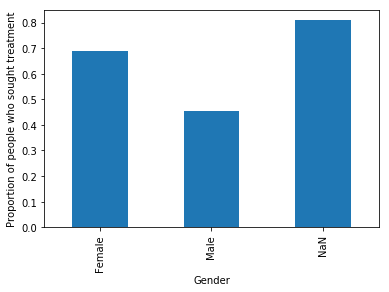

In [12]:
# changing "Yes" and "No" values by 1 and 0 (to make plots possible)
survey.replace(('Yes', 'No'), (1, 0), inplace=True)
gender_pivot = survey.pivot_table(index="Gender",values="treatment")
gender_pivot.plot.bar()
plt.ylabel("Proportion of people who sought treatment")
plt.legend().set_visible(False)
plt.show()

The results for which the gender is unknown (with "NaN" value) are not relevant. <br>
Let's remove all rows where this value appears.

In [13]:
# replacing "NaN" string by np.nan for validity checking
survey['Gender'].replace(["NaN"], np.nan, inplace = True)
survey["Gender"].dropna(inplace=True)

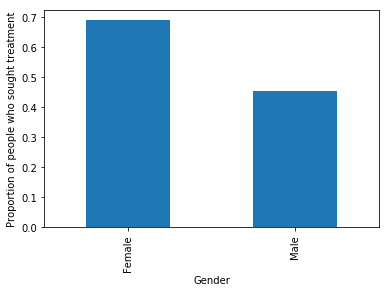

In [14]:
gender_pivot = survey.pivot_table(index="Gender",values="treatment")
gender_pivot.plot.bar()
plt.ylabel("Proportion of people who sought treatment")
plt.legend().set_visible(False)
plt.show()

It seems that more women than men are seeking treatment.

In [15]:
survey["Age"].describe()

count    1.259000e+03
mean     7.942815e+07
std      2.818299e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64

Some values in the "Age" column are not realistic or completely no sense (like negative values or positive values above 150). <br>
Values not between 18 and 73 will be filled by the median value of the column. <br> <br>
Also, as this column is a continuous feature, we'll separate it into a categorical feature by dividing it into ranges (this is called binning).

In [16]:
survey['Age'][survey['Age']<18] = survey['Age'].median()
survey['Age'][survey['Age']>73] = survey['Age'].median()

C:\Users\Ossama\Anaconda3-4.2.0\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# 3. Binning and encoding data

In [17]:
cut_points = [17,30,50,75]
label_names = ["Young Adult","Adult","Senior"]
survey["Age_categories"] = pd.cut(survey["Age"],cut_points,labels=label_names)

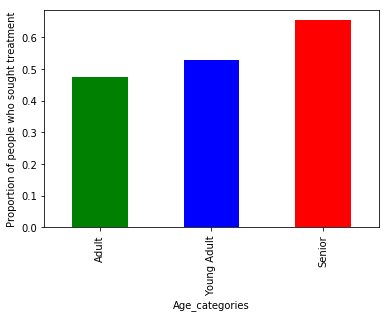

In [18]:
pivot = survey.pivot_table(index="Age_categories",values='treatment')
pivot.plot.bar(color ='gbr')
plt.ylabel("Proportion of people who sought treatment")
plt.legend().set_visible(False)
plt.show()

As our intuition would suggest, the older the person the more likely he/she would seek for treatment. <br> <br>
Most of the columns are non-numerical. We'll need to create dummy columns to make use of these values in our ML models.

In [19]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [20]:
survey = create_dummies(survey,"Age_categories")
survey = create_dummies(survey,"Gender")

In [21]:
survey.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Age_categories',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [22]:
# creating dummy columns for other columns
cols = ['family_history','work_interfere', 'care_options','benefits', 'wellness_program','anonymity',\
        'leave','mental_health_consequence', 'phys_health_consequence']
for column in cols:
    survey = create_dummies(survey,column)

In [23]:
survey.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Age_categories',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Gender_Female', 'Gender_Male',
       'family_history_0', 'family_history_1', 'work_interfere_Don't know',
       'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'care_options_0', 'care_options_1',
       'care_options_Not sure', 'benefits_0', 'benefits_1',
       'benefits_Don't know', 'wellness_program_0', 'wellness_program_1',
       'wellness_program_Don't know', 'anonymit

# 4. Machine Learning Models
## 4.1 Logistic Regression

Now we'll try our first ML model (logistic regression) with two variables only: "Age_categories" and "Gender". <br>
We'll use the dummy columns just created above. <br>
Our metrics will be the accuracy (number of correct predictions / number of total predictions).

In [24]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior',\
           'Gender_Female', 'Gender_Male']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver ='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
predictions = lr.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predictions)
print('Logistic Regression with "Age_categories" and "Gender" variables')
print('Accuracy : {:.3f}'.format(accuracy))

Logistic Regression with "Age_categories" and "Gender" variables
Accuracy : 0.623


The first attempt gives quite poor accuracy. <br>
Let's see if we can improve with cross validation to train and test our model on different splits of our data, and then average the accuracy scores.

In [26]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print('Average accuracy with cross validation (10 folds) : {:.3f}'.format(accuracy))

[0.46153846 0.61538462 0.61538462 0.76923077 0.56       0.68
 0.6        0.6        0.625      0.625     ]
Average accuracy with cross validation (10 folds) : 0.615


Cross validation didn't improve accuracy at all.<br>
Let's try with more features.

In order to select the best-performing features, we need a way to measure which of our features are relevant to our target.<br>
One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.
<br><br>
The scikit-learn LogisticRegression class has an attribute in which coefficients are stored after the model is fit, LogisticRegression.coef_.<br>We first need to train our model, after which we can access this attribute.


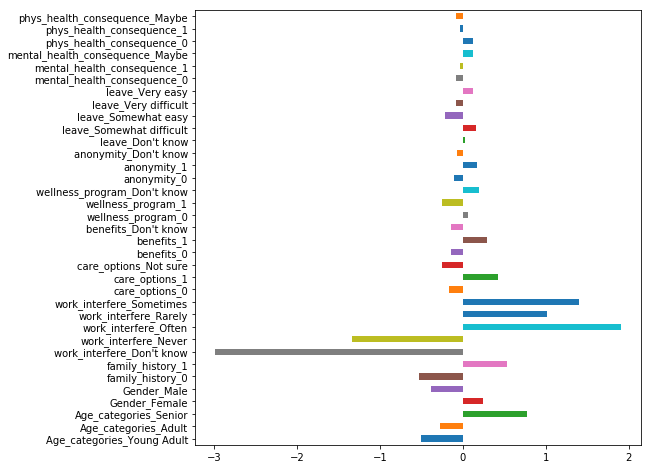

In [27]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',  'Age_categories_Senior',\
                'Gender_Female', 'Gender_Male','family_history_0', 'family_history_1', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'work_interfere_Sometimes', 'care_options_0', 'care_options_1',\
                'care_options_Not sure', 'benefits_0', 'benefits_1',\
                'benefits_Don\'t know', 'wellness_program_0', 'wellness_program_1',\
                'wellness_program_Don\'t know', 'anonymity_0', 'anonymity_1',\
                'anonymity_Don\'t know', 'leave_Don\'t know', 'leave_Somewhat difficult',\
                'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',\
                'mental_health_consequence_0', 'mental_health_consequence_1',\
                'mental_health_consequence_Maybe', 'phys_health_consequence_0',\
                'phys_health_consequence_1', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=X_train[feature_cols].columns)
plt.figure(figsize=(8,8)) 
feature_importance.plot.barh()
plt.show()

The plot we generated just above shows a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value.<br>
To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size.

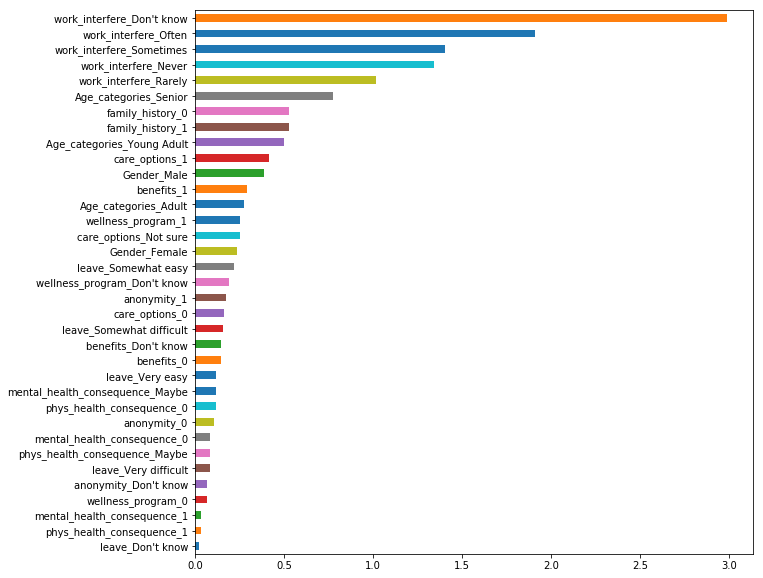

In [28]:
ordered_feature_importance = feature_importance.abs().sort_values()
plt.figure(figsize=(10,10))
ordered_feature_importance.plot.barh()
plt.show()

In [29]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.76923077 0.73076923 0.92307692 0.84615385 0.8        0.84
 0.8        0.72       0.75       0.79166667]
0.7970897435897436


Now let's train a new model with the top n scores (n<8) and check our accuracy using cross validation.

In [30]:
def selectNScores(n):
    feature_cols = ordered_feature_importance.index[-n:]
    X = survey[feature_cols]
    y = survey.treatment
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    
    scores = cross_val_score(lr, X_test, y_test, cv=10)
    accuracy = np.mean(scores)
    print('Average accuracy with the top {:d} feature(s) : {:.3f}'.format(n,accuracy))

In [31]:
for n in range(1,9):
    selectNScores(n)

Average accuracy with the top 1 feature(s) : 0.679
Average accuracy with the top 2 feature(s) : 0.679
Average accuracy with the top 3 feature(s) : 0.758
Average accuracy with the top 4 feature(s) : 0.806
Average accuracy with the top 5 feature(s) : 0.806
Average accuracy with the top 6 feature(s) : 0.806
Average accuracy with the top 7 feature(s) : 0.798
Average accuracy with the top 8 feature(s) : 0.798


It seems that there is an optimal number of features that would be 4 or 5. <br>
But actually, when we look at these top features, we find that they are all related to the "work_interfere" column of the original dataset. <br>
The 5th top feature is just the last dummy column among the 5 possible values of the original "work_interfere" column.
<br> <br>
This is an example of the dummy variable trap. So let's remove one of each of our dummy variables to reduce the collinearity in each.

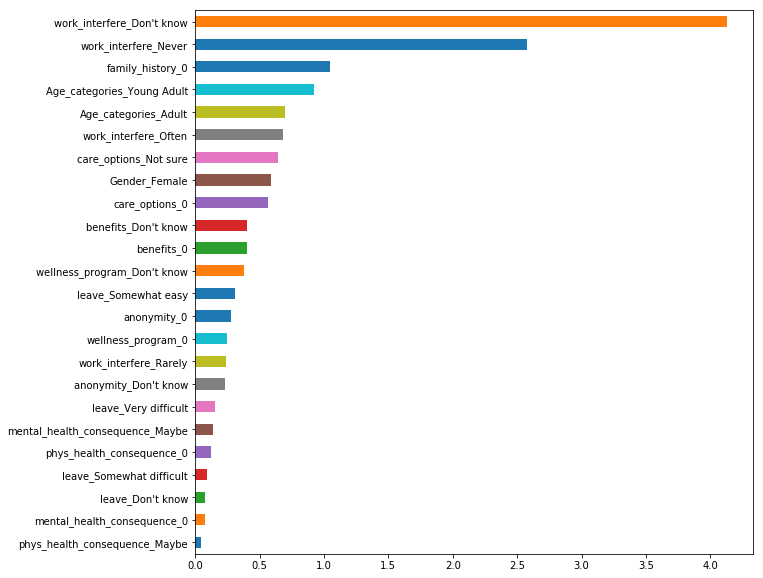

In [32]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',\
                'Gender_Female','family_history_0', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'care_options_0','care_options_Not sure', \
                'benefits_0', 'benefits_Don\'t know',\
                'wellness_program_0', 'wellness_program_Don\'t know',\
                'anonymity_0', 'anonymity_Don\'t know',\
                'leave_Don\'t know', 'leave_Somewhat difficult','leave_Somewhat easy', 'leave_Very difficult',\
                'mental_health_consequence_0', 'mental_health_consequence_Maybe',\
                'phys_health_consequence_0', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=X_train[feature_cols].columns)
ordered_feature_importance = feature_importance.abs().sort_values()
plt.figure(figsize=(10,10))
ordered_feature_importance.plot.barh()
plt.show()

In [33]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.76923077 0.76923077 0.96153846 0.84615385 0.84       0.84
 0.8        0.72       0.75       0.75      ]
0.8046153846153846


In [34]:
for n in range(1,20):
    selectNScores(n)

Average accuracy with the top 1 feature(s) : 0.679
Average accuracy with the top 2 feature(s) : 0.806
Average accuracy with the top 3 feature(s) : 0.806
Average accuracy with the top 4 feature(s) : 0.806
Average accuracy with the top 5 feature(s) : 0.806
Average accuracy with the top 6 feature(s) : 0.806
Average accuracy with the top 7 feature(s) : 0.809
Average accuracy with the top 8 feature(s) : 0.814
Average accuracy with the top 9 feature(s) : 0.797
Average accuracy with the top 10 feature(s) : 0.793
Average accuracy with the top 11 feature(s) : 0.801
Average accuracy with the top 12 feature(s) : 0.797
Average accuracy with the top 13 feature(s) : 0.778
Average accuracy with the top 14 feature(s) : 0.778
Average accuracy with the top 15 feature(s) : 0.778
Average accuracy with the top 16 feature(s) : 0.782
Average accuracy with the top 17 feature(s) : 0.805
Average accuracy with the top 18 feature(s) : 0.801
Average accuracy with the top 19 feature(s) : 0.793


In [35]:
ordered_feature_importance[-8:]

Gender_Female                 0.586833
care_options_Not sure         0.646085
work_interfere_Often          0.684490
Age_categories_Adult          0.699440
Age_categories_Young Adult    0.921201
family_history_0              1.046082
work_interfere_Never          2.574896
work_interfere_Don't know     4.124284
dtype: float64

By avoiding the dummy variable trap, we find a different optimum set of features which seems to make more sense. <br>
Indeed, previously the optimum set was only consisting of values taken by the "work_interfere" column. <br>
Now we have a larger variety of original variables that enable to maximise the performance of our ML model. <br> <br>

For performance comparison, let's try now to select the most relevant features automatically. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation. <br>

The RFECV class starts by training a model using all features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

In [36]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',\
                'Gender_Female','family_history_0', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'care_options_0','care_options_Not sure', \
                'benefits_0', 'benefits_Don\'t know',\
                'wellness_program_0', 'wellness_program_Don\'t know',\
                'anonymity_0', 'anonymity_Don\'t know',\
                'leave_Don\'t know', 'leave_Somewhat difficult','leave_Somewhat easy', 'leave_Very difficult',\
                'mental_health_consequence_0', 'mental_health_consequence_Maybe',\
                'phys_health_consequence_0', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
lr = LogisticRegression(solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
selector = RFECV(lr,cv=10)
selector.fit(X,y)

#we can use the RFECV.support_ attribute to access a boolean mask of True and False values
#which we can use to generate a list of optimized columns
optimized_columns = X.columns[selector.support_]

In [37]:
optimized_columns

Index(['Age_categories_Young Adult', 'Age_categories_Adult', 'Gender_Female',
       'family_history_0', 'work_interfere_Don't know', 'work_interfere_Never',
       'work_interfere_Often', 'work_interfere_Rarely', 'care_options_0',
       'care_options_Not sure', 'benefits_0', 'benefits_Don't know',
       'wellness_program_Don't know', 'anonymity_0', 'anonymity_Don't know',
       'leave_Somewhat difficult', 'leave_Somewhat easy'],
      dtype='object')

In [38]:
X = survey[optimized_columns]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
scores = cross_val_score(lr, X, y, cv=10)
accuracy = np.mean(scores)
print(scores)
print('Average accuracy with recursive feature elimination : {:.3f}'.format(accuracy))

[0.81889764 0.85826772 0.84126984 0.83333333 0.84126984 0.81746032
 0.84920635 0.88       0.816      0.768     ]
Average accuracy with recursive feature elimination : 0.832


Beautiful ! We have improved the accuracy with recursive feature elimination, which shows that this tool is very powerful. <br><br>
Now, let's play with another ML algorithm: k-nearest neighbors algorithm.

## 4.2 k-nearest neighbors algorithm

In [40]:
# applying knn using the maximum number of features first
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',  'Age_categories_Senior',\
                'Gender_Female', 'Gender_Male','family_history_0', 'family_history_1', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'work_interfere_Sometimes', 'care_options_0', 'care_options_1',\
                'care_options_Not sure', 'benefits_0', 'benefits_1',\
                'benefits_Don\'t know', 'wellness_program_0', 'wellness_program_1',\
                'wellness_program_Don\'t know', 'anonymity_0', 'anonymity_1',\
                'anonymity_Don\'t know', 'leave_Don\'t know', 'leave_Somewhat difficult',\
                'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',\
                'mental_health_consequence_0', 'mental_health_consequence_1',\
                'mental_health_consequence_Maybe', 'phys_health_consequence_0',\
                'phys_health_consequence_1', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, X, y, cv=10)
accuracy_knn = scores.mean()
print(scores)
print('Average accuracy with knn (1 neighbor) : {:.3f}'.format(accuracy_knn))

[0.75590551 0.75590551 0.82539683 0.73015873 0.69047619 0.71428571
 0.74603175 0.752      0.656      0.736     ]
Average accuracy with knn (1 neighbor) : 0.736


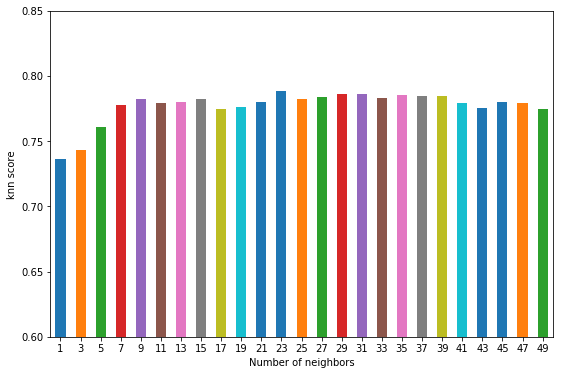

In [42]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.6,0.85),rot=0)
    plt.xlabel('Number of neighbors')
    plt.ylabel('knn score')
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, X, y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn
    
plot_dict(knn_scores)

Even with the optimum number of neighbors (23), the knn algorithm shows lower performance in comparison with logistic regression (accuracy never reaches 0.8). <br>
Let's go further with hyperparameter optimization to see if the knn can perform better.

In [43]:
# automating the process with GridSearch
hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(X, y)

print(grid.best_params_)

{'n_neighbors': 23}


In [44]:
# trying knn with other hyperparameters
hyperparameters = {
    "n_neighbors": range(1,50,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 45, 'p': 1, 'weights': 'uniform'}
0.7831612390786339


Even grid search does not enable to obtain an accuracy higher than 0.8. <br>
Definitely knn is not the best model to use for this challenge.  <br> <br>
Let's try now random forest algorithm.

## 4.3 Random Forest Algorithm

In [45]:
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf,X, y, cv=10)
accuracy_rf = scores.mean()
print('Average accuracy with random forests : {:.3f}'.format(accuracy_rf))

Average accuracy with random forests : 0.797


A cross-validation with random forest regression (without hyperparameter optimisation at the moment) shows better performance than the most optimised knn model. <br>
Let's see how grid search can improve the accuracy.

In [46]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
                    }

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(X, y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print('Best score with random forests : {:.3f}'.format(best_score))

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 9}
Best score with random forests : 0.828


# Conclusion



Working with this dataset has been a very interesting challenge and enabled me to apply my knowledge in data analysis and machine learning. <br> <br>

Cleaning the data, selecting the features, creating new variables are essential steps before selecting the machine learning models and tuning them. <br> <br>

Main conclusions of the exercise are as follows: <br>
 - More women are seeking treatment than men <br>
 - The older the person the more likely he/she would seek for treatment <br>
 - Seeking for treatment is highly correlated to the fact that the person thinks it the mental health would interfere with work <br>
 - Logistic Regression and Random Forest are very good predictors and can give accuracy above 80% if well tuned
